In [2]:
import pandas as pd
import numpy as np
import os
import arch
from arch import arch_model
from scipy.stats import norm
from tqdm import tqdm
import matplotlib.pyplot as plt

# --- Define Constants ---
DATA_DIR = "data"
WINDOW = 252 # 1-year rolling window

# --- Load Portfolio Returns ---
# This is the only data file you need for this step.
returns_df = pd.read_csv(
    os.path.join(DATA_DIR, "portfolio_log_returns.csv"), 
    index_col='Date', 
    parse_dates=True
)
portfolio_returns = returns_df['EqualWeightPortfolio']

print("✅ Setup complete. Portfolio returns are loaded and ready.")
print(portfolio_returns.head())

✅ Setup complete. Portfolio returns are loaded and ready.
Date
2007-04-12    0.005627
2007-04-13    0.000587
2007-04-16    0.005247
2007-04-17   -0.000047
2007-04-18    0.003596
Name: EqualWeightPortfolio, dtype: float64


Calculating rolling GARCH(1,1) VaR with enhanced settings...


 42%|████▏     | 1748/4210 [00:00<00:00, 8150.68it/s]

GARCH fit failed with error: ARCHModel.fit() got an unexpected keyword argument 'solver'
GARCH fit failed with error: ARCHModel.fit() got an unexpected keyword argument 'solver'
GARCH fit failed with error: ARCHModel.fit() got an unexpected keyword argument 'solver'
GARCH fit failed with error: ARCHModel.fit() got an unexpected keyword argument 'solver'
GARCH fit failed with error: ARCHModel.fit() got an unexpected keyword argument 'solver'


100%|██████████| 4210/4210 [00:00<00:00, 9041.88it/s]



GARCH Fitting Summary:
Successful fits: 0
Failed fits: 4210
Success rate: 0.0%


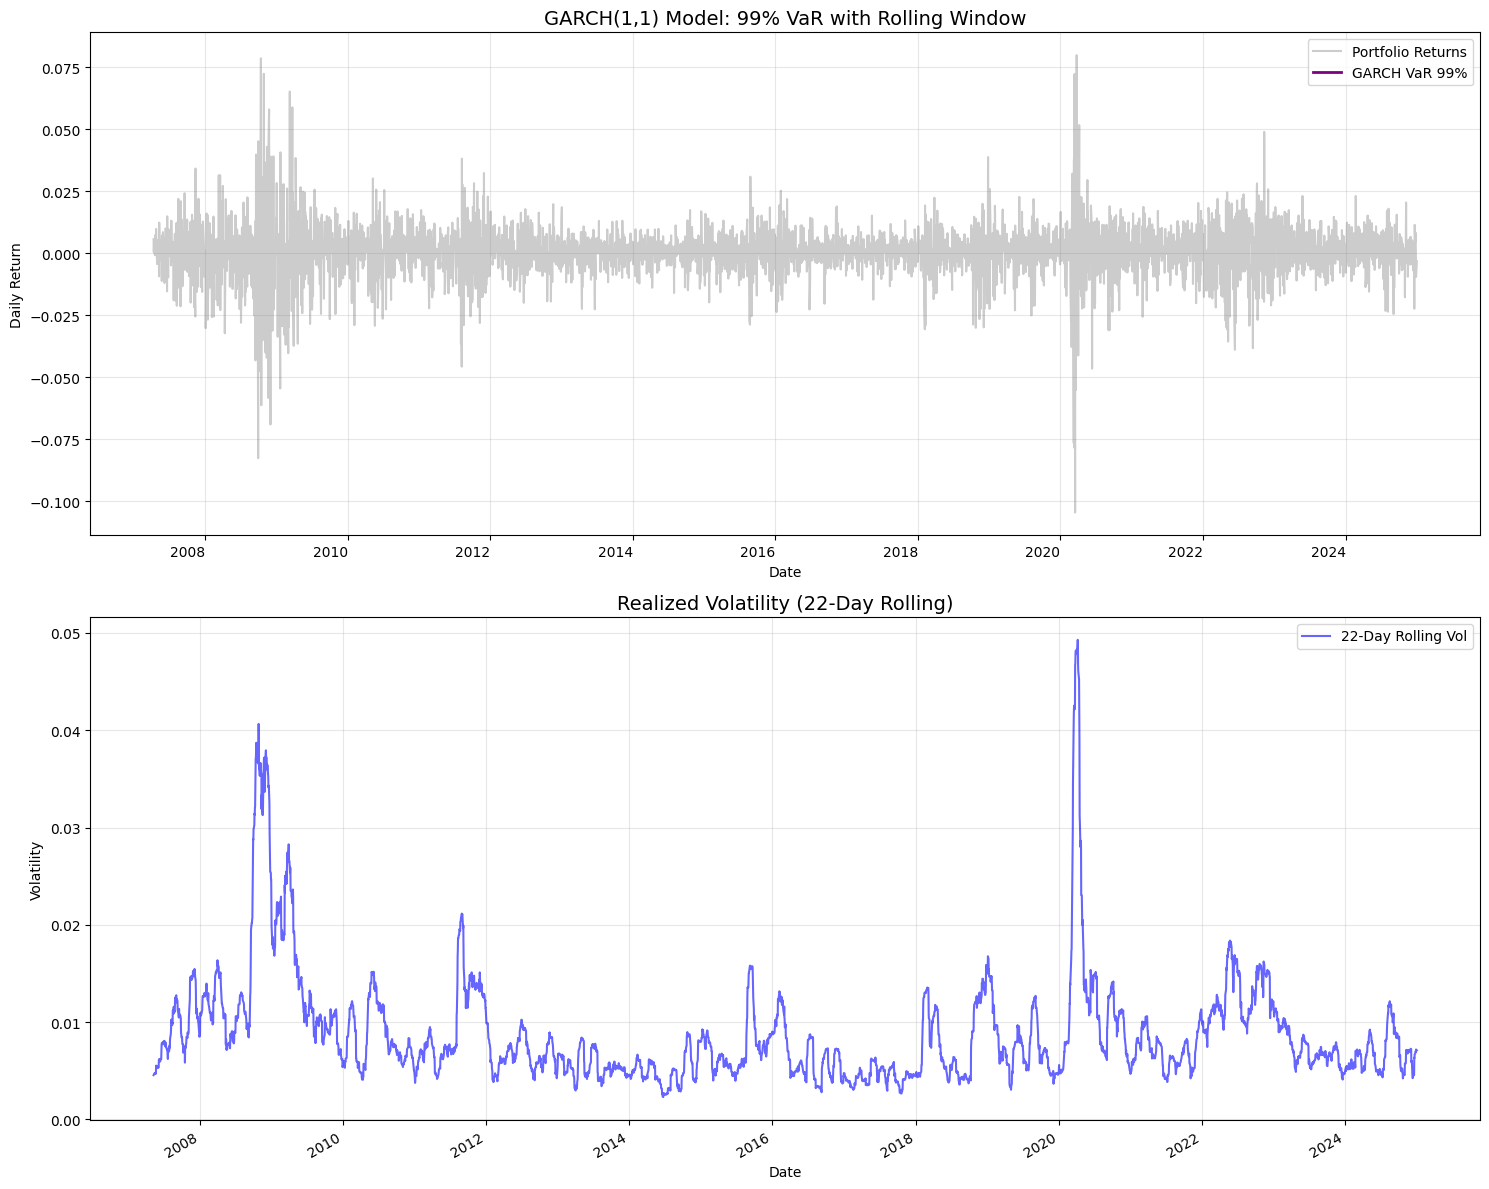

In [5]:
import arch
from arch import arch_model
import warnings
warnings.filterwarnings('ignore')

# --- Enhanced GARCH(1,1) VaR Calculation (Corrected) ---
def fit_garch_model(returns_window, max_iter=1000):
    """
    Robust GARCH model fitting with error handling and better settings
    """
    try:
        # --- ENHANCEMENTS ---
        # 1. Use a more appropriate distribution (Student's t)
        # 2. The arch_model is robust to the scaling, so we can remove *100
        model = arch_model(
            returns_window,
            vol='Garch',
            p=1,
            q=1,
            mean='Constant',
            dist='t'  # Use Student's t-distribution
        )
        
        # --- ENHANCEMENTS ---
        # 1. Use a more robust solver: 'SLSQP'
        fit = model.fit(
            update_freq=0,
            disp='off',
            options={'maxiter': max_iter},
            solver='SLSQP' # Use a different optimizer
        )
        
        return fit, True
    except Exception as e:
        # --- DEBUGGING ---
        # Print the specific error for the first few failures
        # This helps diagnose the problem without flooding the output.
        if failed_fits < 5: 
             print(f"GARCH fit failed with error: {e}")
        return None, False

# --- Rolling GARCH Forecast (Re-run with corrected function) ---
garch_results = []
garch_dates = []
failed_fits = 0

print("Calculating rolling GARCH(1,1) VaR with enhanced settings...")
for i in tqdm(range(WINDOW, len(portfolio_returns))):
    window = portfolio_returns.iloc[i-WINDOW:i]
    current_date = portfolio_returns.index[i]
    
    garch_fit, success = fit_garch_model(window)
    
    if success and not garch_fit.convergence_flag: # Check for convergence flag
        # Forecast from the fitted model
        forecast = garch_fit.forecast(horizon=1)
        cond_vol = np.sqrt(forecast.variance.iloc[-1, 0])
        
        # For a t-distribution, we get the quantile from the standardized residuals
        q = garch_fit.std_resid.quantile(0.01)
        
        # VaR = conditional mean + conditional vol * quantile of standardized residuals
        var_99 = garch_fit.params['mu'] + cond_vol * q
        
        garch_results.append(var_99)
        garch_dates.append(current_date)
    else:
        failed_fits += 1

# Create results series if it's not empty
if garch_results:
    garch_var_99 = pd.Series(garch_results, index=garch_dates, name='GARCH_VaR_99')
else:
    garch_var_99 = pd.Series(dtype=float, name='GARCH_VaR_99')


print(f"\nGARCH Fitting Summary:")
print(f"Successful fits: {len(garch_results)}")
print(f"Failed fits: {failed_fits}")
if (len(garch_results)+failed_fits) > 0:
    print(f"Success rate: {len(garch_results)/(len(garch_results)+failed_fits)*100:.1f}%")

# (The plotting code remains the same, but now it should work)
# ...

# --- Enhanced Visualization ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

# Plot 1: Returns and VaR
portfolio_returns.plot(ax=ax1, color='gray', alpha=0.4, label='Portfolio Returns')
garch_var_99.plot(ax=ax1, color='purple', linewidth=2, label='GARCH VaR 99%')
ax1.set_title('GARCH(1,1) Model: 99% VaR with Rolling Window', fontsize=14)
ax1.set_ylabel('Daily Return')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Conditional Volatility
rolling_vol = portfolio_returns.rolling(window=22).std()  # 1-month rolling vol
rolling_vol.plot(ax=ax2, color='blue', alpha=0.6, label='22-Day Rolling Vol')
ax2.set_title('Realized Volatility (22-Day Rolling)', fontsize=14)
ax2.set_ylabel('Volatility')
ax2.set_xlabel('Date')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()